<a href="https://colab.research.google.com/github/Jheim12/PPHA30456/blob/main/lab_07/ML_lab7_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7 | Dimension Reduction and Tree-Based Methods

In this lab, we cover the following topics:

- Dimension Reduction
    - Principal Component Analysis
    - Principal Component Regression
    - Partial Least Squares
- Decision Trees

### Dimension Reduction

Assume the data contains `p` predictors, however, not all of them are useful. Hence, dimension reduction attempts to improve out-of-sample fit by reducing the complexity to avoid overfitting.

As you already know, there are several methods to achieve this goal:

 - **Subset Selection:** Get rid of some predictors
 - **Shrinkage:** Reduce the influence of some predictors
 - **Dimension Reduction:** Create new predictors that are combinations of original ones

We already saw the two first ones so now we turn our attention to the latter. The idea behind dimension reduction is to create new predictors by projecting the original `p` predictors into a new space (`M` < `p`).

There are two steps to dimension reduction:

1. Define the projection

> Let $ Z = (Z_{1}, ..., Z_{M}) $ represent `M` < `p` combinations of the original `p` predictors:
> $$ Z_{m} = \sum_{j=1}^{p}\phi_{j}^{m}X_{j} $$
> for loadings $ \phi^{m} = (\phi_{1}^{m}, ..., \phi_{p}^{m}) $
> The new predictors (`Z`) are linear combinations of original predictors (X).
>
> ![DimensionReductionSteps](https://raw.githubusercontent.com/Jheim12/PPHA30456/3cdd684f8b768582540beb81e66c24d196c80a3c/lab_07/DimensionReductionSteps.png)

2. Estimate the new OLS model

> Given the new vector of `M` < `p` different Zs, we estimate a new OLS model:
> $$ Y = \theta_{0} + \sum_{m=1}^{M}\theta_{m}Z_{m} + \nu $$

Interestingly, $ \beta_{j} = \sum_{m=1}^{M}\theta_{m}\phi_{j}^{m} $ where $ \beta_{j} $ is the original OLS estimator.

Now, the only question that remains is how to estimate the loadings ($ \phi $). There are two ways of estimating them:

 - **Principal Components Analysis (PCA):** Unsupervised
 - **Partial Least Squares (PLS):** Supervised

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Sci-kit learn
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

##### Principal Component Analysis

The algorithm goes as follows:

 1. The first principal component is the (normalized) linear combination of the predictors with the largest variance: $ max_{{\hat{\phi}}^{1}} \underbrace{\frac{1}{n} \sum_{i=1}^{n} ( \overbrace{\sum_{j=1}^{p} \phi_{j}^{1} x_{ij}}^{z_{1}} )^{2}}_{var(z_{1})} $ subject to $ \sum_{j=1}^{p} (\phi_{j}^{1})^{2} = 1 $.

 2. The second principle component is the (normalized) linear combination of predictors with the largest variance subject to being uncorrelated with the first principle component.

 3. Repeat step 2 until we have `M` principal components.

The issue is that we don't know `M` in advance so we let the data guide us and choose using cross-validation (e.g., elbow method).

To illustrate PCA, we will use the wine dataset we have seen previously. Since PCA is an unsupervised method, we don't need the target variable (i.e., y) so we only have features in this dataset.

In [2]:
# Load the wine data
wine = pd.read_csv('https://raw.githubusercontent.com/Jheim12/PPHA30456/main/lab_07/winequality-red.csv', sep = ';')
X = wine.drop(['quality'], axis = 1)
display(X.head())
display(X.shape)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


(1599, 11)

`sklearn` conveniently does all the work for us when it comes to finding the principal components with the `PCA` method.

For now, let's find all 11 principal components (i.e., no dimension reduction) as we'll decide how many we need later when performing Principal Component Regression (PCR).

Note that scaling is extremely important. Otherwise the variable with the largest values will always be taken as the first principal component. Also, we abstract from the train-test split for now, but you should of course do it and scale the data as previously covered (refer to lab 1 if needed).

In [3]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define and fit the PCA
pca = PCA(n_components = 11)
pcs = pca.fit(X_scaled)

We can find which percentage of the variance is explained by each principal component.

In [4]:
# Display the percentage of variance that is explained
display(list(pcs.explained_variance_ratio_))
pcs.explained_variance_ratio_.sum()

[0.28173931278817266,
 0.1750826990547677,
 0.1409584989795218,
 0.11029386641621117,
 0.08720837012236178,
 0.05996438771540102,
 0.053071929017515396,
 0.03845060905981646,
 0.03133110152897781,
 0.01648483332435506,
 0.005414391992899018]

0.9999999999999998

As we can see, already 28.17% of the variance is explained with the first principal component.

##### Principal Component Regression

Principal Component Regression (PCR) is simply the entire pipeline of first finding the principal components and then running an OLS regression on them. This is where we decide how many principal components to include.

To illustrate it, we'll use last week's bike dataset where we attempt to predict the number of bikes rented with various features relating to the date and weather.

In [5]:
# Load the bike dataset
bike = pd.read_csv('https://raw.githubusercontent.com/Jheim12/PPHA30456/main/lab_07/bike.csv')
bike.drop(['dteday'], axis=1, inplace=True)
display(bike.head())
display(bike.shape)

# Separate X and y
X = bike.drop(['cnt'], axis = 1)
y = bike['cnt']

# Do a 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


(17379, 16)

In machine learning, we often use pipelines into which we can input data that gets transformed (e.g., normalized, principal components) to then estimate a model (e.g., linear regression).

![Pipelines](https://raw.githubusercontent.com/Jheim12/PPHA30456/3cdd684f8b768582540beb81e66c24d196c80a3c/lab_07/Pipelines.png)

Let's start with 5 principal components.

In [6]:
# Define the PCR pipeline
pcr = make_pipeline(
    StandardScaler(),       # First transformer
    PCA(n_components=5),    # Second transformer
    LinearRegression()      # Estimator
)

# Fit the PCR pipeline on the training data
pcr.fit(X_train, y_train)

# Assess the fit using the test data
y_predict = pcr.predict(X_test)
mean_squared_error(y_test, y_predict)

10763.099321747724

Is this the best number of components? Let's try with every possible number for `M`.

Text(0.5, 1.0, 'Principal Component Regression')

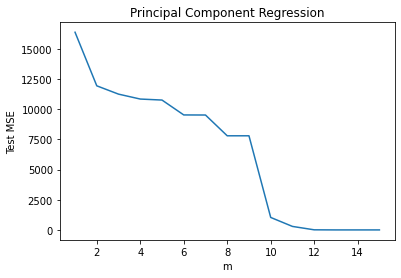

In [7]:
# Storing the MSEs
test_mse = {}

# Perform PCR for all possible number of principal components
for m in range(1, X_train.shape[1]+1):
    pcr = make_pipeline(
        StandardScaler(),
        PCA(n_components=m),
        LinearRegression()
    ).fit(X_train, y_train)

    test_mse[m] = mean_squared_error(
        y_test,
        pcr.predict(X_test)
    )

# Visualize the results
plt.figure(facecolor='white')
plt.plot(list(test_mse.keys()), list(test_mse.values()))
plt.xlabel('m')
plt.ylabel('Test MSE')
plt.title('Principal Component Regression')

We will use the elbow method to determine the optimal number of principal components. Essentially, you want to select the point where there was just a big drop in accuracy and there isn't a large improvement in accuracy afterwards. This means that the principal components that improve the accuracy a lot are included while those with only marginal benefits are not. In other words, we get rid of the principles components that add noise.

So, we now find that 5 is not the optimal number of principal components at all! Instead, 10 principal components seem to be the sweetspot.

### Partial Least Squares

Like Principal Component Regression, Partial Least Squares (PLS) is a dimension reduction method. However, it is a supervised method because it uses the outcome, Y, when computing the loadings.

The Partial Least Squares algorithm goes as follows:

1. Standardize the `p` predictors
2. For each predictor `j`, estimate a simple linear regression of Y on $ X_{j} $: $ y_{i} = \hat{\beta}_{0} + \hat{\beta}_{j}x_{ij} + \hat{e}_{i} $
3. Compute the first direction $ z_{i1} = \hat{\phi}_{1}^{1}x_{i1} + ... + \hat{\phi}_{p}^{1}x_{ip} $ by setting each $ \hat{\phi}_{j}^{1} = \hat{\beta}_{j}\ \forall\ j $
4. For each predictor j, predict the residuals, $ \hat{u}_{ij} $, from a simple linear regression of $ X_{j} $ on $ Z_{1} $: $ x_{ij} = \hat{\alpha}_{0} + \hat{\alpha}_{j}z_{i1} + \hat{u}_{ij}\ \forall\ j $
5. Replace $ X_{j} $ with $ \hat{u}_{ij} $ and repeat steps 2-5 

Let's first see how 5 principal components do when using PLS!

In [8]:
# Partial least squares with 5 principal components
pls = PLSRegression(n_components=5, scale=True)
pls.fit(X_train, y_train)

# Evaluate the model
y_predict = pls.predict(X_test)
mean_squared_error(y_test, y_predict)

15.866880245098567

Again, there is no guarantee that 5 principal components are optimal so we'll use the elbow technique again!

Text(0.5, 1.0, 'Partial Least Squares')

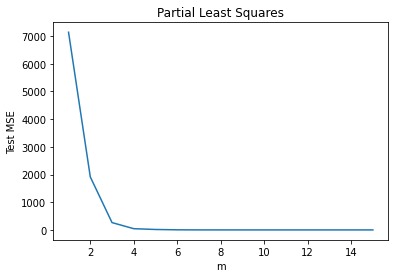

In [9]:
# Storing the MSEs
test_mse = {}

# Perform PCR for all possible number of principal components
for m in range(1, X_train.shape[1]+1):
    pls = PLSRegression(
        n_components=m,
        scale=True
    ).fit(X_train, y_train)
    
    test_mse[m] = mean_squared_error(
        y_test,
        pls.predict(X_test)
    )

# Visualize the results
plt.figure(facecolor='white')
plt.plot(list(test_mse.keys()), list(test_mse.values()))
plt.xlabel('m')
plt.ylabel('Test MSE')
plt.title('Partial Least Squares')

It looks like either 2 or 3 components are optimal according to the elbow-technique!

### Decision Trees

Decision trees are beloved by many because they are quite intuitive and easily interpretable.

The hierarchical structure of a decision tree leads us to the final outcome by traversing through the nodes of the tree. Each node consists of an attribute or feature which is further split into more nodes as we move down the tree.

It uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves).

Essentially, once the tree is built, it is really easy to make predictions. However, building the tree turns out to be a lot more difficult. It is so difficult and complex that we spend over 100 slides on them in the lectures! For brevity, we won't go over the details here, but give you a brief summary of the most important building blocks to develop the necessary intuition.

In essence, tree divide a space, but finding the optimal way to divide it is too costly in terms of computations (there is a nearly infinite way of dividing even just a 2D space up). Thus, we will use recursive binary splitting:

- **Recursive:** Treats every branch recursively so the algorithm goes down a branch until it finds a leaf before rolling back and going down the next branch.
- **Binary:** Each node will have two children (expect if it is a leaf, then 0)
- **Splitting:** Well, we do split, don't we?

Below, the numbered red arrows illustrate how the tree gets built using recursion. Notice that each internal node has exactly two children because of the binary aspect.

![RecursiveBinarySplitting](https://raw.githubusercontent.com/Jheim12/PPHA30456/3cdd684f8b768582540beb81e66c24d196c80a3c/lab_07/RecursiveBinarySplitting.png)

Formally, the algorithm goes as follows:

1. Select the best predictor `j` and cutpoint `s` such that we split the predictor space into two regions, $ R_{1}(j, s) = {X|X_{j} < s}\ and\ R_{2}(j, s) = {X|X_{j} >= s} $, that lead to the largest decrease in RSS.
2. Select the next best predictor `j` and cutpoint `s` so that it further splits an existing region into two regions, $ R_{1}(j, s)\ and\ R_{2}(j, s) $, that lead to the largest decrease in RSS.
    - Almost repeats the previous step but instead of splitting the entire predictor space but instead of splitting the entire predictor space, it splits one of the existing regions.
3. Repeat step 2 until a stopping criterion is reached
    - `max_depth`: Maximum depth of the tree
    - `min_samples_leaf`: Minimum number of samples that must be in a leaf
    - `max_leaf_nodes`: Maximum number of leaf nodes
    - `min_impurity_decrease`: Split a node only if it decreases its impurity by at least a minimum amount
    - etc.

Now we know almost everything but how to define the best split at a given node. For this, we use splitting measures like Gini Index, Information Gain, etc.

The Gini index or Gini impurity measures the degree or probability of a particular variable being wrongly classified when it is randomly chosen. Formally: $ G = \sum_{k=1}^K \hat{p}_{lk}(1-\hat{p}_{lk}) $

Hence, $ G \in [0, 1] $ where 0 indicates that all observations in a node are from the same class and 1 indicates perfect impurity (i.e., 50% of observations are from each of the two possibles classes).

The recursive binary splitting algorithm will use the Gini index to determine which predictor `j` and cutpoint `s` to use by looking which combination offers be lowest Gini score in the resulting children.

Alright, now that we have a theoretical understanding of decision trees, let's look into how they work in practice.

We will attempt to determine whether a patient has diabetes or not based on various physiological indicators.

In [10]:
# Load the data
feature_names = [
    'Number of times pregnant', 'Plasma glucose concentration',
    'Diastolic blood pressure', 'Triceps skinfold thickness',
    'Serum insulin','BMI','Diabetes pedigree function','Age',
    'Diabetes?'
]

data = pd.read_csv("https://raw.githubusercontent.com/Jheim12/PPHA30456/main/lab_07/pima-indians-diabetes.csv", names = feature_names)

display(data.head())
display(data.describe())

,Number of times pregnant,Plasma glucose concentration,Diastolic blood pressure,Triceps skinfold thickness,Serum insulin,BMI,Diabetes pedigree function,Age,Diabetes?
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


,Number of times pregnant,Plasma glucose concentration,Diastolic blood pressure,Triceps skinfold thickness,Serum insulin,BMI,Diabetes pedigree function,Age,Diabetes?
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Of course, since we are performing classification, we need to know our baseline. This is the frequency of the most common class or, in other words, the percentage of correct predictions we would get if we were to always predict the most frequent class.

In [11]:
# Split into X and y
X = data.drop(['Diabetes?'], axis = 1)
y = data['Diabetes?']

# Baseline accuracy
print(y.value_counts())
print(f'\nBaseline Accuracy: {y.value_counts().values.max()/len(y)}')

0    500
1    268
Name: Diabetes?, dtype: int64

Baseline Accuracy: 0.6510416666666666


Alright, it looks like we'll need to get a better accuracy that 65%. Let's see what we can do.

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state = 1)

Before trying to play around with the various parameters, let's understand how the algorithm decides which splits to do. We saw that the algorithm will recursively choose the predictor and cutoff that reduce the (training) RSS the most.

Let's use 2 features in this simple example so that we can visualize the predictor space.

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


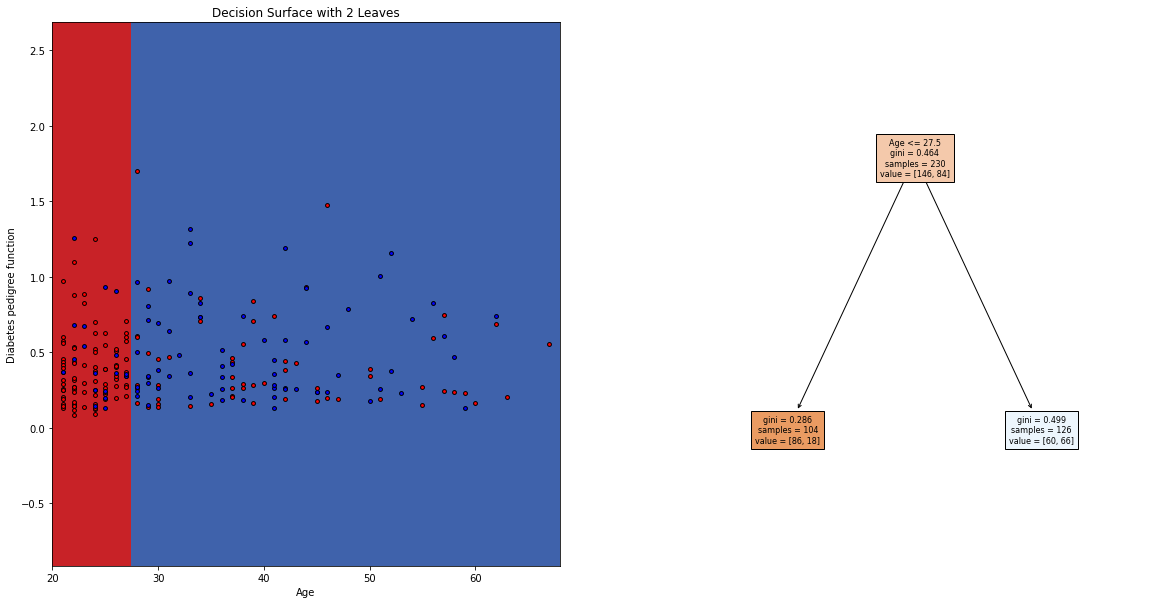

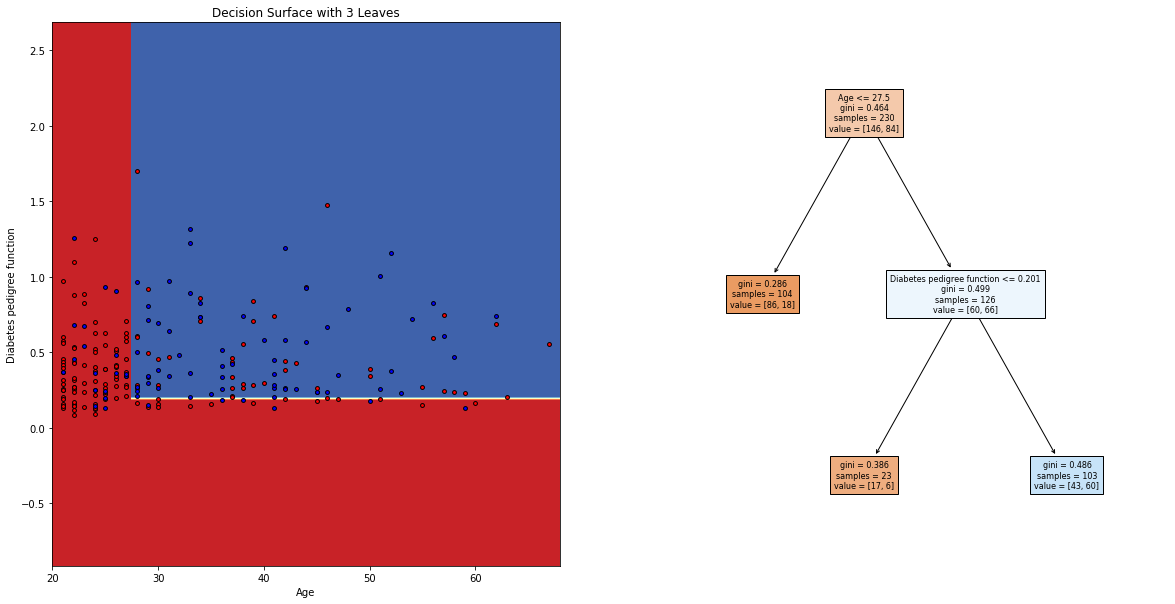

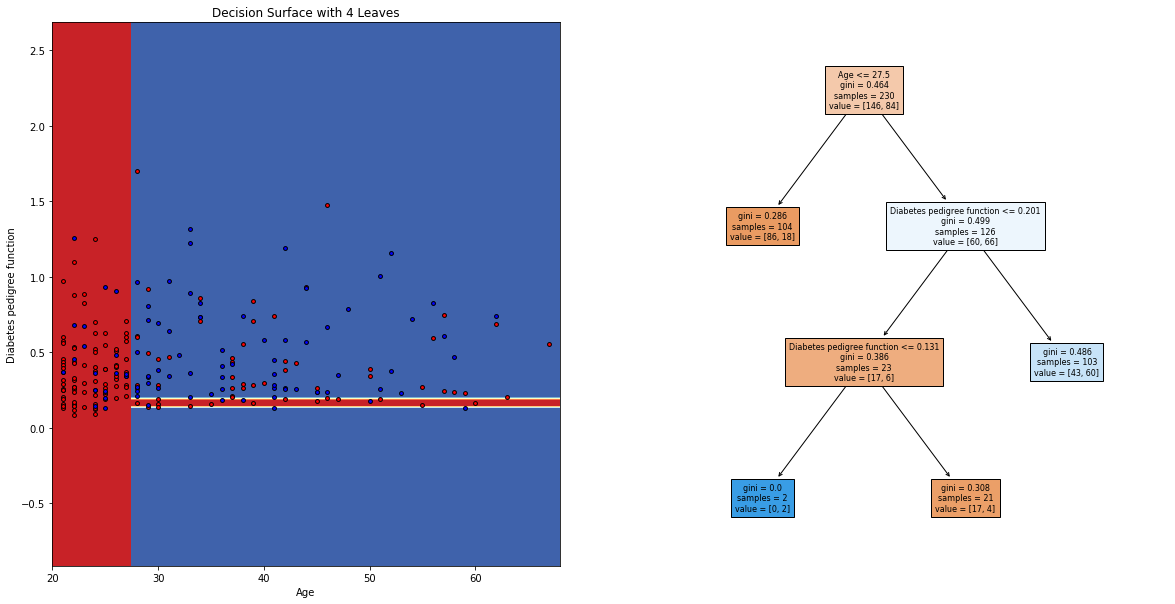

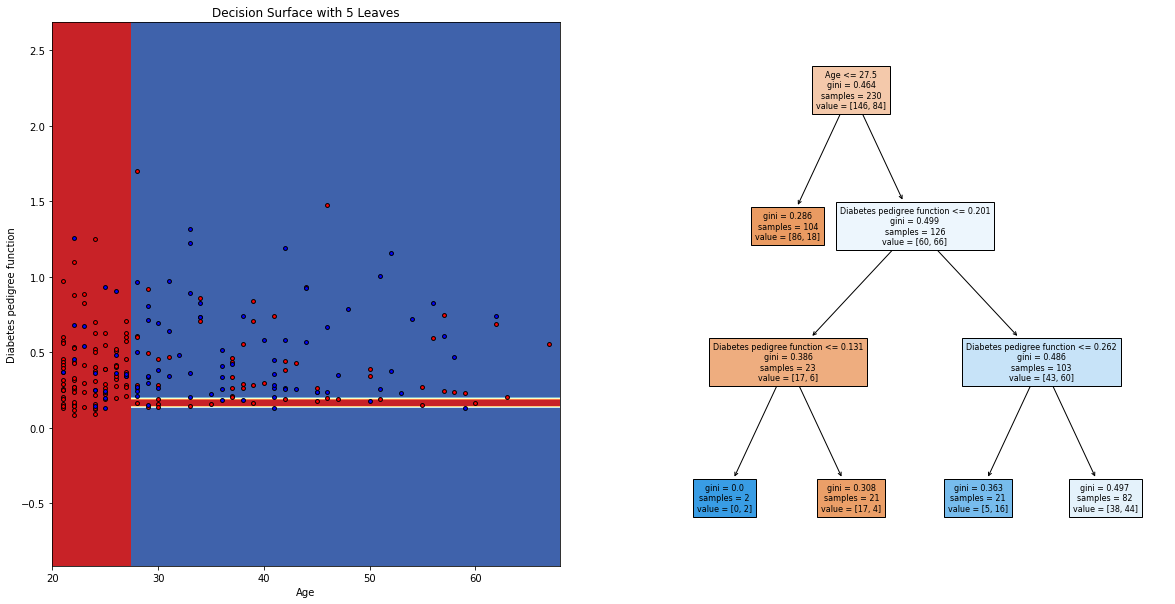

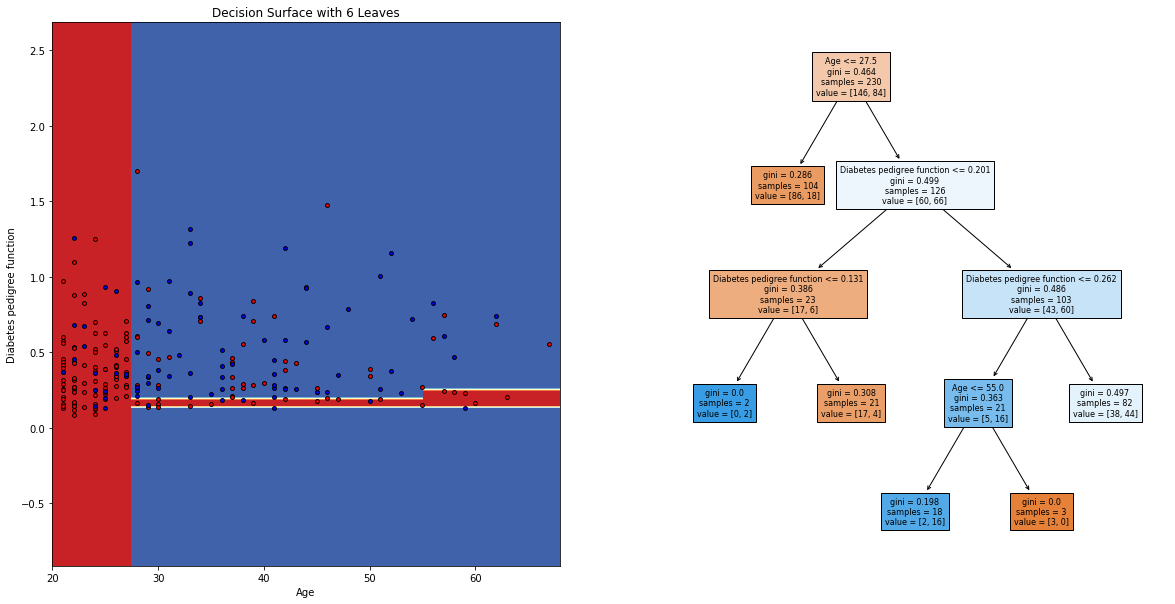

In [13]:
# Use only 2 features
features_2D = [
    'Age',
    'Diabetes pedigree function'
]

X_train_2D = X_train[features_2D]

# Make the tree iteratively larger
for max_leaves in range(2, 7):
    
    # Fit the model with an increasing maximum depth
    model = DecisionTreeClassifier(
        max_leaf_nodes=max_leaves,
        random_state=1,
        criterion='gini'
    ).fit(X_train_2D, y_train)

    # Compute the decision areas
    plot_step = 0.02
    x1_min, x1_max = X_train_2D.iloc[:, 0].min() - 1, X_train_2D.iloc[:, 0].max() + 1
    x2_min, x2_max = X_train_2D.iloc[:, 1].min() - 1, X_train_2D.iloc[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, plot_step),
        np.arange(x2_min, x2_max, plot_step)
    )
    Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)

    # Plot the decision areas
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].contourf(xx1, xx2, Z, cmap=plt.cm.RdYlBu)

    # Plot the training observations
    for i, color in zip(range(2), 'rb'):
        idx = np.where(y_train == i)[0]
        axs[0].scatter(
            X_train_2D.iloc[idx, 0],
            X_train_2D.iloc[idx, 1],
            c=color,
            cmap=plt.cm.RdYlBu,
            edgecolor='black',
            s=15
        )
    
    # Plot the tree
    axs[1] = tree.plot_tree(
        model,
        fontsize=8,
        feature_names=features_2D,
        filled=True
    )

    # Plot aestetics
    axs[0].set(
        title=f'Decision Surface with {max_leaves} Leaves',
        xlabel=features_2D[0],
        ylabel=features_2D[1]
    )

As one can see, it is quite easy to spot where the splits happen and how the decision area rapidly becomes more complex.

As we increase `max_leaf_nodes`, the number of splits increases gradually. Note that sometimes a split is made that does not seem to have any impact because it still predicts the same class for both children. However, it still decreases the impurity and give the opportunity to further split the subspaces. In our example, you can see that this happens we we add the fifth leaf. This split decreases the impurity score (Gini) from 0.486 to (21\*0.363 + 82\*0.497)/(21 + 82) = 0.470 and is later used by the sixth split to further refine the predictions.

Anyways, let's start playing around with those parameters. Most interestingly, we can tweak the stopping criterion, but let's see what would happen if we were not to specify any.

Training Accuracy: 1.0
Test Accuracy: 0.6468401486988847


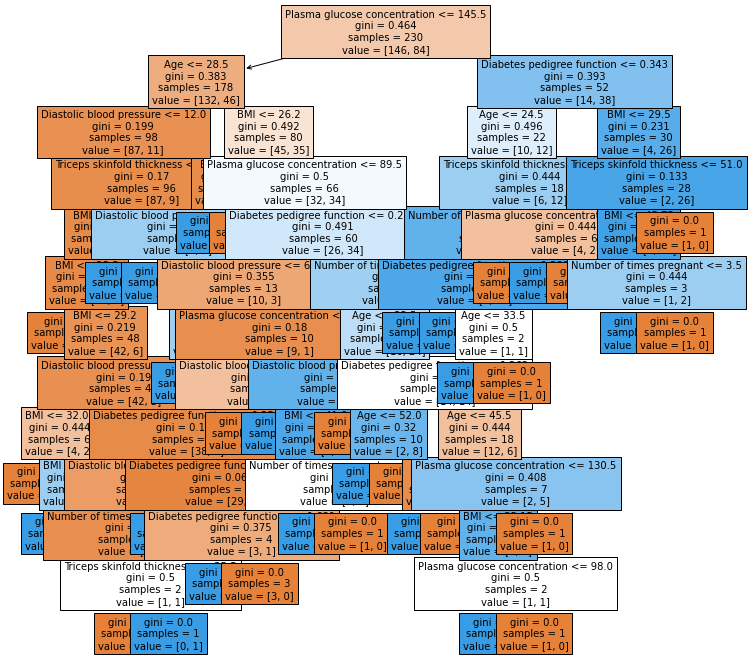

In [14]:
# No stopping criterion
model = DecisionTreeClassifier(
    random_state=12,
    criterion='gini').fit(X_train, y_train)

print(f'Training Accuracy: {model.score(X_train, y_train)}')
print(f'Test Accuracy: {model.score(X_test, y_test)}')

plt.figure(figsize=(12,12), facecolor='white')
tree.plot_tree(model, fontsize=10, feature_names=X_train.columns, filled=True)
plt.show()

As one would expect, the tree gets fully specified. In other words, each node only contains observations from one class. We can see that this is true as the training accuracy is 1. Obviously, we are facing major overfitting as the test accuracy is lower than the baseline. What a mess! We're doing worse than an uneducated guess!

Alright, let's see what these stopping criteria can do for us. First, let's specify the maximum depth as it is the most intuitive. Essentially, we tell the tree that it is not allowed to go beyond a certain depth, no matter what.

Training Accuracy: 0.782608695652174
Test Accuracy: 0.671003717472119


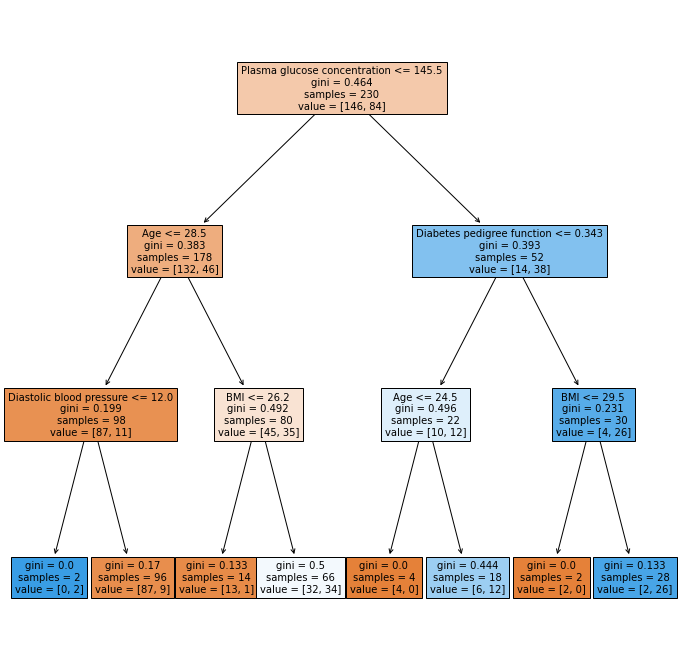

In [15]:
# Maximum depth
model = DecisionTreeClassifier(
    max_depth=3,
    random_state=1,
    criterion='gini').fit(X_train, y_train)

print(f'Training Accuracy: {model.score(X_train, y_train)}')
print(f'Test Accuracy: {model.score(X_test, y_test)}')

plt.figure(figsize=(12,12), facecolor='white')
tree.plot_tree(model, fontsize=10, feature_names=X_train.columns, filled=True)
plt.show()

Already much better! Notice how the tree is perfectly symmetric. This is typical when using `max_depth` as the stopping criterion as the only reason a branch would not reach the maximum depth is if an ('internal') node is perfectly homogeneous.

Another popular stopping criterion is `min_samples_leaf` where we can say how many observations need to be in a leaf. If there are less than the given threshold, we don't allow the (parent) node to split.

Training Accuracy: 0.7391304347826086
Test Accuracy: 0.7472118959107806


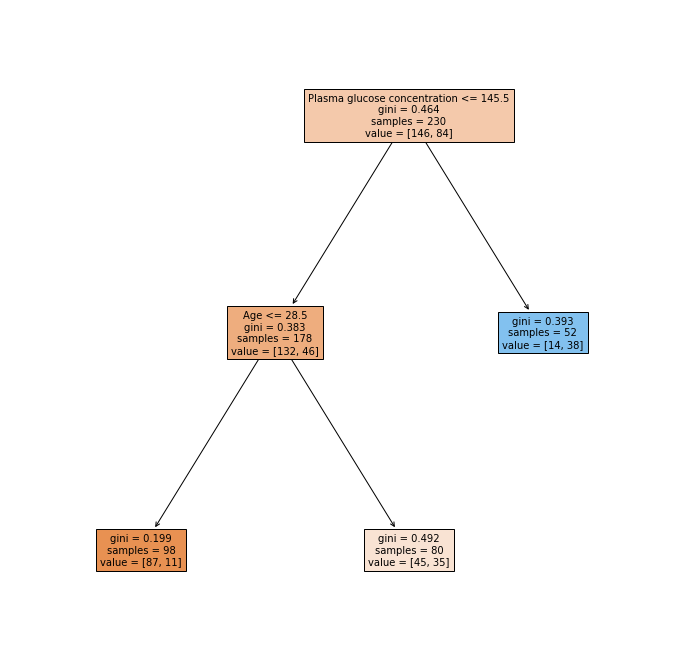

In [16]:
# Minimum number of samples in each leaf
model = DecisionTreeClassifier(
    min_samples_leaf=50,
    random_state=1,
    criterion='gini').fit(X_train, y_train)

print(f'Training Accuracy: {model.score(X_train, y_train)}')
print(f'Test Accuracy: {model.score(X_test, y_test)}')

plt.figure(figsize=(12,12), facecolor='white')
tree.plot_tree(model, fontsize=10, feature_names=X_train.columns, filled=True)
plt.show()

Unlike `max_depth`, you are likely to get "unbalanced" decision trees when using `min_samples_leaf`.

One can also specify the maximum number of leaves on a tree with `max_leaf_nodes`.

Training Accuracy: 0.8130434782608695
Test Accuracy: 0.7286245353159851


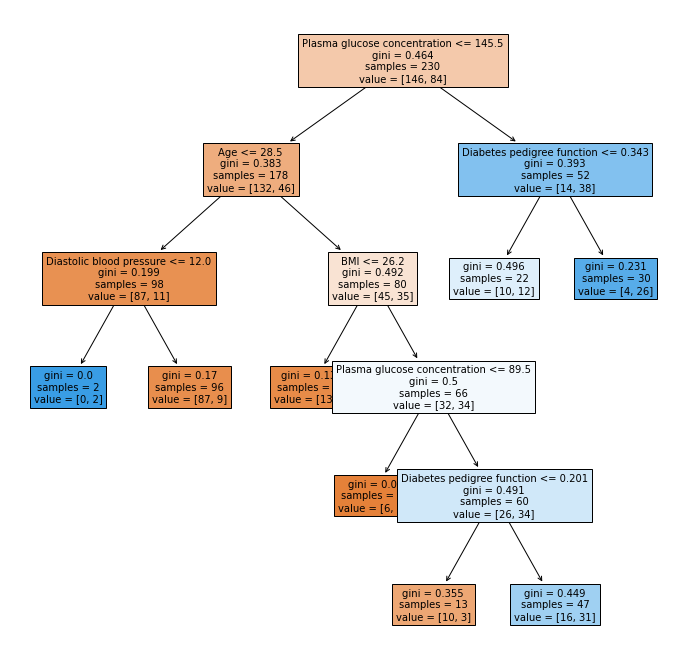

In [17]:
# Maximum number of leaves
model = DecisionTreeClassifier(
    max_leaf_nodes=8,
    random_state=1,
    criterion='gini').fit(X_train, y_train)

print(f'Training Accuracy: {model.score(X_train, y_train)}')
print(f'Test Accuracy: {model.score(X_test, y_test)}')

plt.figure(figsize=(12,12), facecolor='white')
tree.plot_tree(model, fontsize=10, feature_names=X_train.columns, filled=True)
plt.show()

As expected, we get 8 leaves.

Finally, the last stopping criterion we will cover is `min_impurity_decrease`. It determines by how much the score used to compute the purity of a node (e.g., Gini) needs to decrease to allow a split to happen.

Training Accuracy: 0.7391304347826086
Test Accuracy: 0.7472118959107806


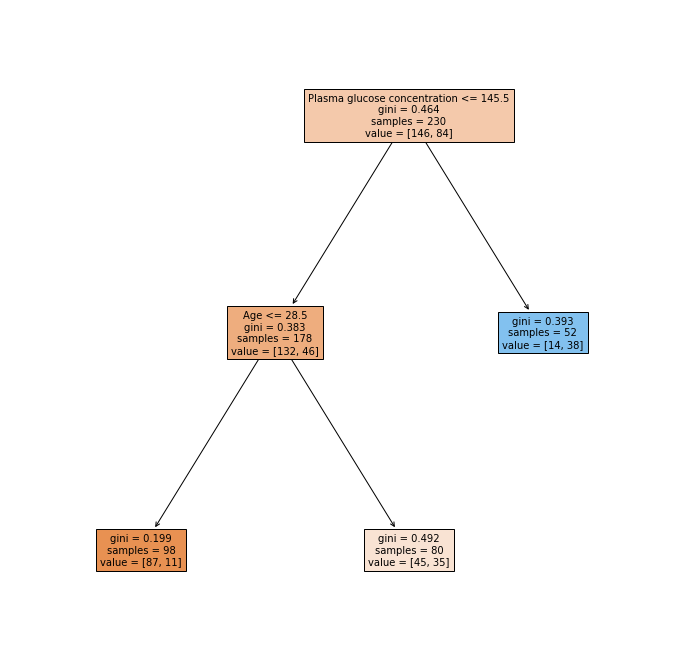

In [18]:
# Minimum decrease in impurity
model = DecisionTreeClassifier(
    min_impurity_decrease=0.02,
    random_state=1,
    criterion='gini').fit(X_train, y_train)

print(f'Training Accuracy: {model.score(X_train, y_train)}')
print(f'Test Accuracy: {model.score(X_test, y_test)}')

plt.figure(figsize=(12,12), facecolor='white')
tree.plot_tree(model, fontsize=10, feature_names=X_train.columns, filled=True)
plt.show()

One can observe that only splits that result in a Gini improvement (i.e., decrease) by at least 0.02 took place.

Of course, the accuracy score (i.e., fraction of correctly predicted observations) is not the only relevant metric to make a decision. One might care about which class we make mistakes on. To evaluate the true/false positives/negatives, we bring back one of our long forgotten old friends; the confusion matrix.

Text(30.5, 0.5, 'Actual Values')

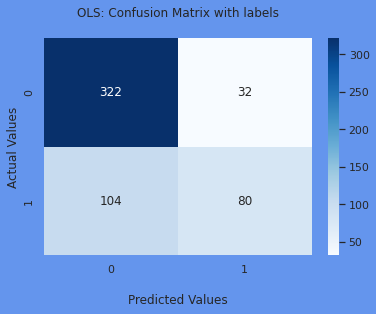

In [19]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, model.predict(X_test))

sns.set(rc={'figure.facecolor': 'cornflowerblue'})
ax = sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
ax.set_title('OLS: Confusion Matrix with labels\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

Luckily, we have already covered the confusion matrix in depth so you should be able to evaluate it on your own.

Anyways, it does look like the stopping criterion is something we should optimize. Let's use the `min_impurity_decrease` but you would of course also look at choosing the best criterion, not just the best threshold for a given criterion.

Text(0, 0.5, 'CV Score (Accuracy)')

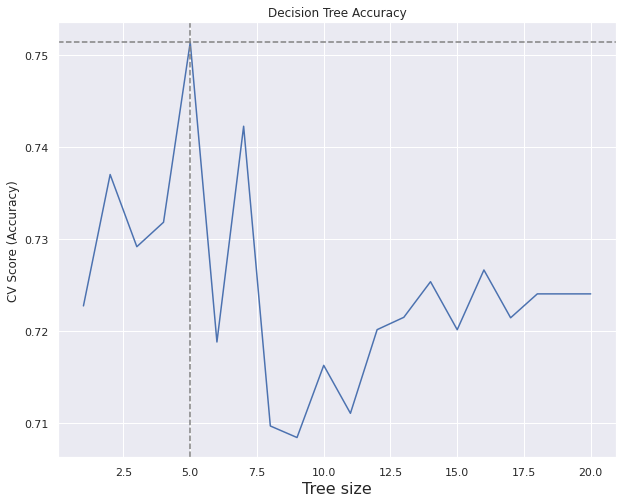

In [20]:
# Define the model
model = DecisionTreeClassifier(
    random_state=1,
    criterion='gini')

# Use GridSearchCV to iterate over a number of maximum depths
tree_depths = np.arange(1, 21, 1)
parameters = {'max_depth': tree_depths}
cv_tree = GridSearchCV(model, parameters, scoring='accuracy')
cv_tree.fit(X, y)

# Extract the accuracy scores
cv_scores = []
for mean_score in zip(cv_tree.cv_results_["mean_test_score"]):
    cv_scores.append(mean_score[0])

# Plot the accuracies
plt.figure(figsize=(10,8), facecolor='white')
sns.lineplot(x=tree_depths, y=cv_scores)

# Highlight the best accuracy
plt.axhline(y=max(cv_scores), color = 'grey', linestyle = '--')
plt.axvline(x=tree_depths[cv_scores.index(max(cv_scores))], color = 'grey', linestyle = '--')

# Add labels
plt.title('Decision Tree Accuracy')
plt.xlabel("Tree size", fontsize= 16)
plt.ylabel('CV Score (Accuracy)')

We find that a maximum depth of 5 is ideal as it gives us the highest cross-validated test accuracy. Let's see what that tree actually looks like.

Training Accuracy: 0.8826086956521739
Test Accuracy: 0.6877323420074349


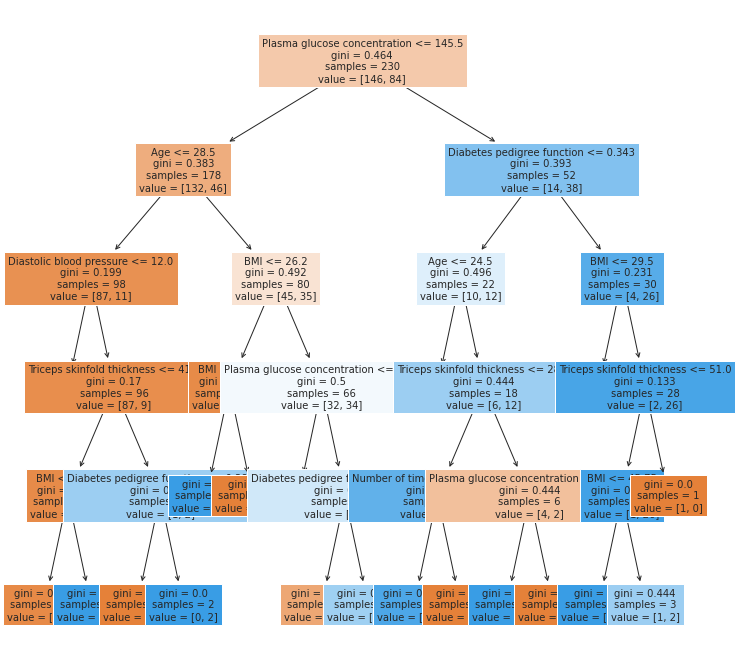

In [21]:
# Decision tree with a maximum depth of 5
model = DecisionTreeClassifier(
    random_state=12,
    max_depth=5,
    criterion='gini').fit(X_train, y_train)

print(f'Training Accuracy: {model.score(X_train, y_train)}')
print(f'Test Accuracy: {model.score(X_test, y_test)}')

plt.figure(figsize=(12,12), facecolor='white')
tree.plot_tree(model, fontsize=10, feature_names=X_train.columns, filled=True)
plt.show()

_**Postscript:** While writing this lab, I kept wondering why I constantly typed leafs instead of leaves. Soon, I figured out that it is because of the Toronto Maple Leafs, a Canadian NHL team. I always thought that they were named after the leaf of the maple tree, the national symbol of Canada, and that, therefore, the plural of leaf was leafs. It turns out that the Toronto Maple Leafs are named after the Maple Leaf regiment of the Canadian Army. I wonder what else will take me over a decade to figure out. - Jonas (2023)_